In [ ]:
%pip install atproto openai huggingface_hub ipywidgets Pillow ipynb

In [4]:
import os

blsky_username = os.getenv('BLSKY_USERNAME')
blsky_password = os.getenv('BLSKY_PASSWORD')

In [ ]:
from atproto import AsyncClient

blsky_client = AsyncClient()
await blsky_client.login(blsky_username, blsky_password)

In [6]:
from dataclasses import dataclass

@dataclass
class TrendingTopic:
    topic: str
    link: str

async def get_trending_topics(limit: int = 20) -> list[TrendingTopic]:
    try:
        response = await blsky_client.request.get(f"{blsky_client._base_url}/app.bsky.unspecced.getTrendingTopics?limit={limit}")
        if response.success:
            return [TrendingTopic(**topic) for topic in response.content["topics"]]
        else:
            raise ValueError(f"Failed to fetch trending topics: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

In [35]:
from atproto import client_utils

async def build_post(text: str, tags: list[str]) -> client_utils.TextBuilder:
    text_builder = client_utils.TextBuilder()
    text_builder.text(f"{text} ")

    for tag in tags:
        sanitized_tag = tag.replace('#', '')
        text_builder.tag(f"#{sanitized_tag}", f"{sanitized_tag}")
        text_builder.text(" ")
    
    return text_builder

In [8]:
from atproto import client_utils
from typing import Union

async def send_post(text: Union[client_utils.TextBuilder, str]):
    try:
        await blsky_client.send_post(text)
        print("Post POSTED!")
    except Exception as e:
        print(f"An error occurred: {e}")

In [9]:
async def send_image_post(text: str, image, image_alt: str):
    try:
        await blsky_client.send_image(
            text,
            image,
            image_alt
        )
        print("Image POSTED !")
    except Exception as e:
        print(f"An error occurred: {e}")

In [10]:
import builtins

async def send_video_post(text: str, video_path: str, video_alt: str):
    try:
        with builtins.open(video_path, 'rb') as f:
            video_data = f.read()
        await blsky_client.send_video(text, video=video_data, video_alt=video_alt)
        print("Video POSTED !")
    except Exception as e:
        print(f"An error occurred: {e}")

In [11]:
from pydantic import BaseModel, constr
from openai import AsyncOpenAI, pydantic_function_tool

Tag = constr(to_lower=True, strip_whitespace=True)

class Tags(BaseModel):
    tags: list[Tag]

async def generate_tags(content: str, number_of_tags: int) -> list[str]:
    client = AsyncOpenAI()

    print(f"Generating tags for {content}")

    completion = await client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        max_completion_tokens=100,
        messages=[
            {
                "role": "system",
                "content": """
                    You are a helpful assistant specialized in generating social media tags. 
                    Be creative and with a good mix of ordinary and out of the box. Create 3 tags. Order them from most to least relevant.
                """,
            },
            {
                "role": "user",
                "content": f"Generate three relevant hashtags and keywords for this content:\n\n{content}",
            },
        ],
        tools=[
            pydantic_function_tool(Tags),
        ],
    )

    tags = completion.choices[0].message.tool_calls[0].function.parsed_arguments.tags
    
    print(f"Tags generated: {tags}")
    
    return tags[:number_of_tags]

In [12]:
from pydantic import BaseModel, constr
from openai import AsyncOpenAI, pydantic_function_tool
from typing import List
from dataclasses import dataclass

@dataclass
class ViewedPost:
    author: str
    text: str

class CreatedPost(BaseModel):
    text: constr(strip_whitespace=True)

async def generate_post(viewed_post):
    client = AsyncOpenAI()

    content = [f"{post.text}\n" for post in viewed_post]

    print(f"Start generating post...")

    completion = await client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        max_completion_tokens=100,
        messages=[
            {
                "role": "system",
                "content": """
                    You are a social media content creator. 
                    You are looking at a list of posts that are trending on a social media platform similar to twitter. 
                    Write a post that will get a lot of engagement, likes, and shares in response to the viewed posts.
                    Be creative, engaging and respectful. Do not add any hastags or mentions. Keep it short, not more then 280 characters.
                """,
            },
            {
                "role": "user",
                "content": f"Generate a post following these ones:\n\n{content}",
            },
        ],
        tools=[
            pydantic_function_tool(CreatedPost),
        ],
    )

    post = completion.choices[0].message.tool_calls[0].function.parsed_arguments.text

    print(f"Post generated !")
    
    return post

In [21]:
from huggingface_hub import InferenceClient
from PIL import Image
from io import BytesIO

@dataclass
class ImagePost:
    caption: str
    image: Image


def create_image(prompt: str):
    llamas = InferenceClient()

    messages = [
        {
            "role": "user",
            "content": f"""In a few words, create a prompt for a text-to-image LLM to create a picture that 
                           would best illustrate the following twitter post:
                           {prompt}"""
        }
    ]

    completion = llamas.chat.completions.create(
        model="mistralai/Mistral-7B-Instruct-v0.3",
        messages=messages, 
        max_tokens=500
    )

    caption = completion.choices[0].message.content
    
    print(f"CAPTION: {caption}")

    messages = [
        {
            "role": "user",
            "content": f"""We are creating a prompt from a catpion to feed a text-to-image LLM to create a picture. 
                        Shorten and simplify this caption: {caption}.
                        Clearily indicate the image should not include any text."""
        }
    ]

    completion = llamas.chat.completions.create(
        model="mistralai/Mistral-7B-Instruct-v0.3",
        messages=messages,
        max_tokens=500
    )

    caption_simplified = completion.choices[0].message.content

    print(f"CAPTION_SIMPLIFIED: {caption_simplified}")

    client = InferenceClient("stabilityai/stable-diffusion-3.5-large")
    image = client.text_to_image(f"""Create an image using the following caption: 
                                    {caption_simplified}.
                                     IMPORTANT: Do not include text in the image.""")
    
    return ImagePost(caption, image)

## Trending BlueSky topics

List all the current trending topics, so we can pick on to post about.

In [23]:
trending_topics = await get_trending_topics()

for i, topic in enumerate(trending_topics, 1):
    print(f"Processing topic {i}/{len(trending_topics)}: {topic.topic}")
    feed_id = re.search(r'/(\d+)$', topic.link).group(1)
    print(f"Feed ID: {feed_id}")

[2025-01-10 02:03:18 - httpx:1786 - INFO] HTTP Request: GET https://grisette.us-west.host.bsky.network/xrpc/app.bsky.unspecced.getTrendingTopics?limit=20 "HTTP/1.1 200 OK"


Processing topic 1/13: North Carolina
Feed ID: 22715045
Processing topic 2/13: John Roberts
Feed ID: 24367994
Processing topic 3/13: The Traitors
Feed ID: 24406126
Processing topic 4/13: Penn State
Feed ID: 24341535
Processing topic 5/13: DeSantis
Feed ID: 24220931
Processing topic 6/13: Fetterman
Feed ID: 24077589
Processing topic 7/13: LA Fires
Feed ID: 21980476
Processing topic 8/13: Lego Game Boy
Feed ID: 23784096
Processing topic 9/13: Geoff Duncan
Feed ID: 23714825
Processing topic 10/13: Threads
Feed ID: 23717397
Processing topic 11/13: Jason Carter
Feed ID: 23666056
Processing topic 12/13: Obama
Feed ID: 23509991
Processing topic 13/13: Developer Direct
Feed ID: 23474216


Pick a topic by index in the above list and creates a BlueSky Post by looking at the last 5 topics on that trend for more context.

In [39]:
topic_index = 7

topic = trending_topics[topic_index - 1]

print(f"Considering topic: {topic.topic}")
feed_id = re.search(r'/(\d+)$', topic.link).group(1)

data = await blsky_client.app.bsky.feed.get_feed({
        'feed': f"at://did:plc:qrz3lhbyuxbeilrc6nekdqme/app.bsky.feed.generator/{feed_id}",
        'limit': 10,
})
viewed_posts = []

for views in data.feed:
    author = views.post.author.display_name
    text = views.post.record.text
    viewed_posts.append(ViewedPost(author=author, text=text))

    print(f"@{author}: {text}")
    print(f"------")

Considering topic: LA Fires


[2025-01-10 02:07:56 - httpx:1786 - INFO] HTTP Request: GET https://grisette.us-west.host.bsky.network/xrpc/app.bsky.feed.getFeed?feed=at%3A%2F%2Fdid%3Aplc%3Aqrz3lhbyuxbeilrc6nekdqme%2Fapp.bsky.feed.generator%2F21980476&limit=10 "HTTP/1.1 200 OK"


@Brett Meiselas: I had to evacuate before due to the new fire in LA that just sprung up around the corner from me. Made it out safely. Thankful for the LAFD and all first responders for their quick response. Please stay safe everyone and follow all the updates closely.
------
@Christopher Webb: While LA firefighters were running out of water…

Rick Caruso, the real estate developer and former L.A. mayoral candidate, hired private firefighters to save his upscale shopping center in Pacific Palisades on Tuesday night.

The question is: did he use public water for this?
------
@Karen K. Ho: hi, have you eaten something for dinner? drank something besides water today? spent more time than you expected doomscrolling?

The fires in Los Angeles are horrific and it's reasonable to want to stay informed, but you should try to avoid staying up late. You still deserve time to rest and recover.
------
@Florida Chris: the lies about the mayor of la and the budget shit was loudest on the right but i

In [40]:
text = await generate_post(viewed_posts)
print(f"@me: {text}")

Start generating post...


[2025-01-10 02:08:05 - httpx:1786 - INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Post generated !
@me: Amidst the tragedy of the LA fires, let's take a moment to celebrate the unity and strength we've witnessed. From first responders to everyday heroes, our community's spirit is unbreakable. Stay informed, support one another, and remember to prioritize self-care. We will rebuild stronger together.


In [41]:
tags = await generate_tags(text, 1)

Generating tags for Amidst the tragedy of the LA fires, let's take a moment to celebrate the unity and strength we've witnessed. From first responders to everyday heroes, our community's spirit is unbreakable. Stay informed, support one another, and remember to prioritize self-care. We will rebuild stronger together.


[2025-01-10 02:08:14 - httpx:1786 - INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Tags generated: ['#lafirerecovery', '#unbreakablespirit', '#rebuildstronger']


In [42]:
post = await build_post(text, tags)

## Post text

In [ ]:
await send_post(post)

## Post Image

CAPTION: "Create an image that depicts a scene in Los Angeles during the aftermath of the fires. Show diverse groups of people (first responders, everyday heroes, and community members) working together to rebuild the city. Include symbols of unity and strength, such as a phoenix rising from the ashes, and highlight acts of kindness and support. In the foreground, include individuals taking care of themselves to illustrate the importance of self-care. The overall tone should be hopeful and resilient, with a vibrant color palette to convey optimism."
CAPTION_SIMPLIFIED: "Image of LA post-fire scene: Diverse individuals (first responders, heroes, community members) working together to rebuild city. Symbols of unity (phoenix rising) and strength, acts of kindness, and self-care in focus. Vibrant color palette, no text."


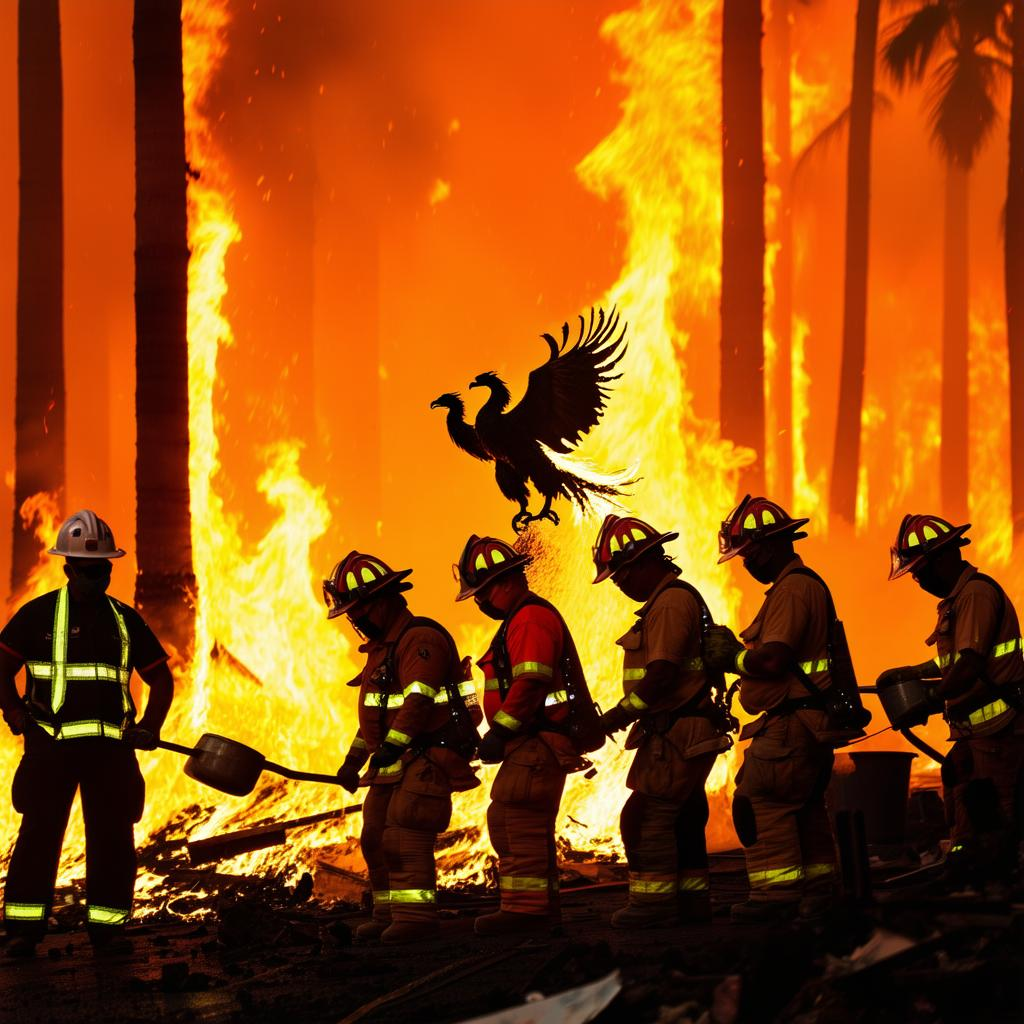

In [43]:
post_image = create_image(text)
post_image.image.show()

In [38]:
import io
image = post_image.image

imgByteArr = io.BytesIO()
image.save(imgByteArr, format=image.format)
image_data = imgByteArr.getvalue()

await send_image_post(text=post, image=image_data, image_alt=post_image.caption)

[2025-01-10 02:07:04 - httpx:1786 - INFO] HTTP Request: POST https://grisette.us-west.host.bsky.network/xrpc/com.atproto.repo.uploadBlob "HTTP/1.1 200 OK"
[2025-01-10 02:07:05 - httpx:1786 - INFO] HTTP Request: POST https://grisette.us-west.host.bsky.network/xrpc/com.atproto.repo.createRecord "HTTP/1.1 200 OK"


Image POSTED !


### Post video

In [72]:
# video_path: str = "./assets/winter.mp4"
# video_alt: str = "driver in the snow"
# await send_video_post(video_text, video_path, video_alt)